# Multivariate Process Monitoring: Fault Detection, Diagnosis, and Prognosis using PCA, Takens-PCA, CVA, and CVDA

Modern industrial processes such as chemical plants, water treatment systems, and manufacturing lines generate large amounts of sensor data capturing temperatures, flows, 
pressures, and chemical compositions.  These datasets are high-dimensional and correlated, making it difficult to understand the system’s behavior from raw variables alone. 
Principal Component Analysis (PCA) simplifies complex process data by transforming correlated  variables into a smaller set of uncorrelated components that explain most of the variance. Using PCA, we can visualize hidden structures, identify key process factors, and interpret how sensors co-vary during normal operations. This study seeks to understand the health of an industrial process by addressing three fundamental questions:
1. Has a fault occured? (Fault Detection)
2. Where did it occur? (Fault Diagnosis)
3. How will it progress in the future? (Fault Prognosis)


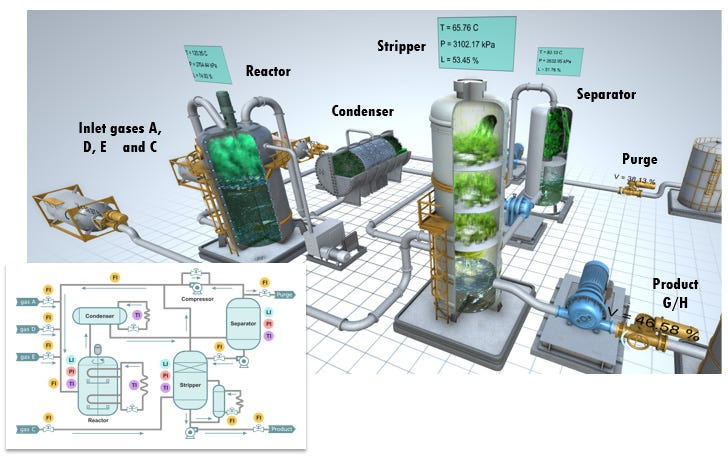


# 1. Setup and Theme
Import core libraries, apply a consistent purple theme, and define a helper to confirm that the TEP dataset is loaded.

In [7]:
from pathlib import Path
from typing import List
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

TE_PURPLE = "#4d0031"
sns.set_theme(style="whitegrid", context="notebook", palette=[TE_PURPLE])

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=[TE_PURPLE])
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["font.family"] = "DejaVu Sans"

# Heatmap colors
CORR_CMAP = sns.diverging_palette(200, 20, as_cmap=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_PATH = Path("TEP_FULL_3YEARS.txt")
MAX_ROWS = 200_000


def ensure_data_loaded() -> None:
    """
    Load dataset once and create global views.

    This version is more memory-friendly:
    - Reads at most MAX_ROWS rows.
    - Downcasts numeric columns to float32.
    """
    global df, df_num, df_features, status_col, xmeas_cols, xmv_cols

    if "df" in globals():
        return

    if not DATA_PATH.exists():
        raise FileNotFoundError(
            f"Dataset not found at: {DATA_PATH} "
            "– put readme.txt in the same folder as this notebook."
        )


    df_raw = pd.read_csv(
        DATA_PATH,
        sep=";",
        engine="python",
        nrows=MAX_ROWS,
        low_memory=True,
    )

    df_local = df_raw.copy()

    # Treat first column as time/index
    time_col = df_local.columns[0]
    df_local[time_col] = pd.to_datetime(
        df_local[time_col], errors="ignore"
    )
    df_local = df_local.set_index(time_col)

    #  Detect STATUS column
    status_candidates = [
        c for c in df_local.columns if "STATUS" in c.upper()
    ]
    status_local = status_candidates[0] if status_candidates else "STATUS"

    # Select numeric columns and downcast to float32 to save memory
    df_num_local = df_local.select_dtypes(include="number").copy()
    for col in df_num_local.columns:
        df_num_local[col] = df_num_local[col].astype("float32")

    # Features = all numeric except STATUS (if present)
    if status_local in df_num_local.columns:
        df_features_local = df_num_local.drop(columns=[status_local])
    else:
        df_features_local = df_num_local

    # Identify XMEAS and XMV groups
    xmeas_cols_local = [
        c for c in df_features_local.columns
        if c.upper().startswith("XMEAS")
    ]
    xmv_cols_local = [
        c for c in df_features_local.columns
        if c.upper().startswith("XMV")
    ]

    # Expose globals (smaller, float32)
    df = df_local
    df_num = df_num_local
    df_features = df_features_local
    status_col = status_local
    xmeas_cols = xmeas_cols_local
    xmv_cols = xmv_cols_local

    print("Data loaded (truncated):", df.shape)
    print("STATUS column:", status_col)
    print("# XMEAS:", len(xmeas_cols), "| # XMV:", len(xmv_cols))

ensure_data_loaded()

# 2. Data Background

## 2.1. Data span, granularity, and basic validation

Before looking at faults and time-series behaviour, we first check:

- **What period** the data covers (start and end time)
- **How often** measurements are recorded (sampling interval)
- **How large** the dataset is (rows × columns)
- **Basic data quality**: missing values and duplicate rows

These checks tell us whether the dataset is suitable for time-series analysis
and whether we need to worry about gaps or obvious data issues.


In [8]:
ensure_data_loaded()

# Time span
index = df.index
start_time = index.min()
end_time = index.max()

print("Data span:")
print("  Start:", start_time)
print("  End:  ", end_time)

# Granularity: estimate median time step if index is datetime-like
if np.issubdtype(index.dtype, np.datetime64):
    deltas = index.to_series().diff().dropna()
    median_delta = deltas.median()
    print("\nApproximate sampling interval (median):", median_delta)
else:
    print("\nIndex is not datetime; sampling interval not available.")

# Size
n_rows, n_cols = df.shape
print(f"\nData size: {n_rows:,} rows × {n_cols} columns")

# Missing values
missing_pct = (df.isna().mean() * 100).round(3)
print("\nMissing values (%):")
display(missing_pct.to_frame("missing_pct").head(10))

# Duplicates
n_duplicates = df.duplicated().sum()
print("\nDuplicate rows:", n_duplicates)


Data span:
  Start: 1970-01-01 00:00:00
  End:   1971-02-21 15:57:00

Approximate sampling interval (median): 0 days 00:03:00

Data size: 200,000 rows × 54 columns

Missing values (%):


,missing_pct
XMEAS(1),0.0
XMEAS(2),0.0
XMEAS(3),0.0
XMEAS(4),0.0
XMEAS(5),0.0
XMEAS(6),0.0
XMEAS(7),0.0
XMEAS(8),0.0
XMEAS(9),0.0
XMEAS(10),0.0



Duplicate rows: 0


# 3. Exploratory Data Analysis

## 3.1 Counts and types of faults (Normal vs Faulty)

We next look at how often the plant operates in:

- a **normal state** (status = 0), and  
- **faulty states** (status ≠ 0), which include different faults
  and disturbed operating modes.

This tells us if we have:

- enough normal data to learn a baseline, and  
- enough examples of fault behaviour to analyse detection and diagnosis.


Binary status distribution (0 = Normal, 1 = Faulty):


,percent
status_binary,
0,51.8
1,48.2


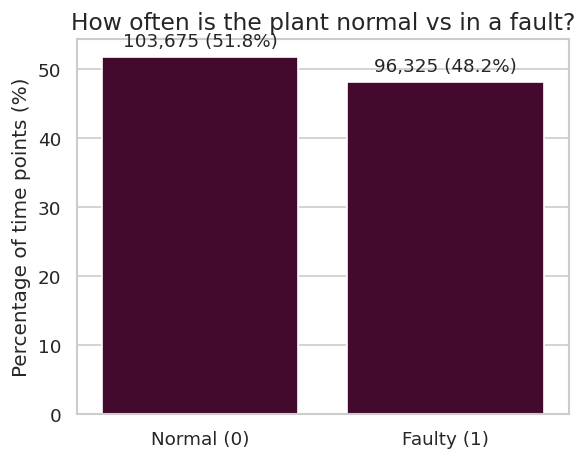

General finding: In this dataset, the plant operates in a normal condition for about 51.8% of the time and spends roughly 48.2% of the time in some faulty state.


In [9]:
ensure_data_loaded()

# Binary recode: 0 = Normal (STATUS == 0), 1 = Faulty (STATUS 1–20)
df["status_binary"] = np.where(df[status_col] == 0, 0, 1)

binary_counts = df["status_binary"].value_counts().sort_index()
binary_perc = (binary_counts / binary_counts.sum() * 100).round(1)

print("Binary status distribution (0 = Normal, 1 = Faulty):")
display(binary_perc.to_frame("percent"))

# Bar plot showing percentage of time in each state
labels = ["Normal (0)", "Faulty (1)"]
y_vals = [binary_perc.get(0, 0.0), binary_perc.get(1, 0.0)]

fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(x=labels, y=y_vals, color=TE_PURPLE, ax=ax)

ax.set_ylabel("Percentage of time points (%)")
ax.set_title("How often is the plant normal vs in a fault?")

# Add count + percent on top of each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    count = int(binary_counts.iloc[i])
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,  # small offset above bar
        f"{count:,} ({height:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=11,
    )

plt.tight_layout()
plt.show()

# One general finding
normal_pct = binary_perc.get(0, 0.0)
faulty_pct = binary_perc.get(1, 0.0)

print(
    f"General finding: In this dataset, the plant operates in a normal "
    f"condition for about {normal_pct:.1f}% of the time and spends roughly "
    f"{faulty_pct:.1f}% of the time in some faulty state."
)

## 3.2 XMEAS(9) – How a Key Variable Behaves Over Time

To make the time-series nature of the data concrete, we focus on one
important measured variable, **XMEAS(9)** (e.g., reactor temperature).

We want to see whether:

- it moves smoothly over time or jumps randomly, and  
- it behaves like a **heartbeat** of the plant (continuous fluctuations
  around a target).


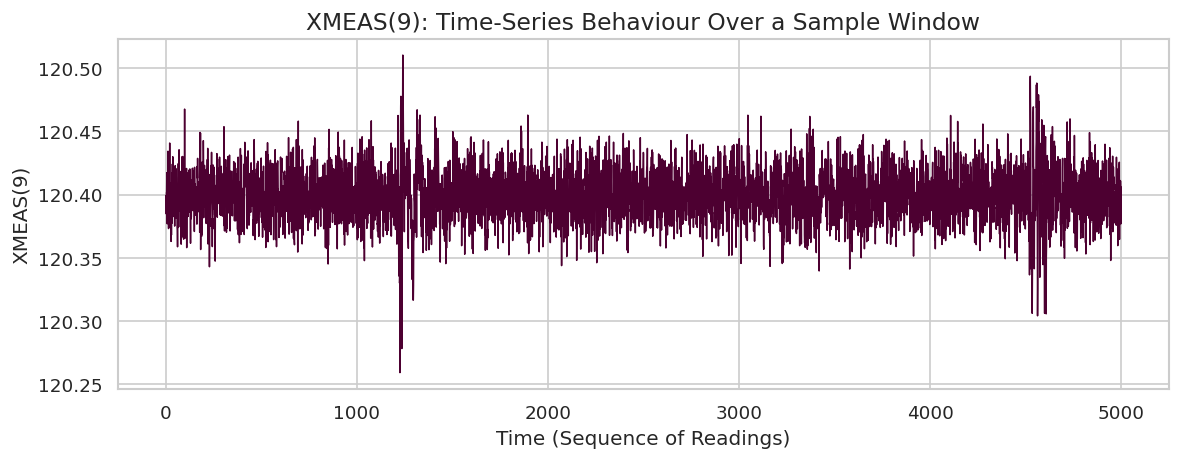

In [10]:
ensure_data_loaded()

if "XMEAS(9)" in df_features.columns:
    ts_var = "XMEAS(9)"
else:
    ts_var = df_features.columns[0]

n_points = min(5000, len(df_features))
series_ts = df_features[ts_var].iloc[:n_points]

plt.figure(figsize=(10, 4))
plt.plot(series_ts.values, linewidth=0.9, color=TE_PURPLE)
plt.xlabel("Time (Sequence of Readings)")
plt.ylabel(ts_var)
plt.title(f"{ts_var}: Time-Series Behaviour Over a Sample Window")
plt.tight_layout()
plt.show()

**Interpretation**

- The trajectory of **XMEAS(9)** is smooth and continuous: it does not jump
  wildly between unrelated values.
- It fluctuates within a **stable band**, rising and falling gently rather
  than drifting away.
- This is exactly what we expect from a **controlled process variable** in
  a chemical plant: always moving, but kept near a target.

## 3.3 Stationarity, Trend, and Variability (ARIMA view)

For time-series modelling (including ARIMA and dynamic PCA), we need to
know whether a variable:

- is **stable around a mean** (stationary-like), or  
- shows a clear **trend** or long-term drift.

We examine XMEAS(9) again and look at:

- its **rolling mean** (average) over time, and  
- its **rolling standard deviation** (variability) over time.

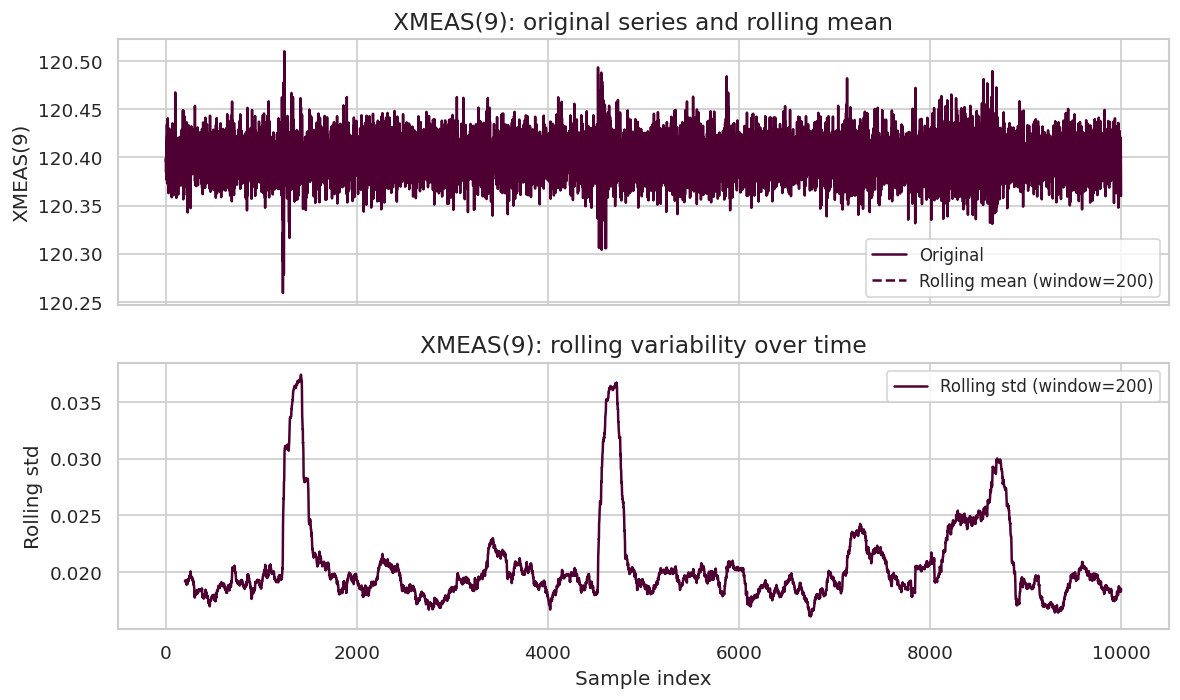

ADF statistic: -20.659402326433106
p-value: 0.0


In [11]:
ensure_data_loaded()

if "XMEAS(9)" in df_features.columns:
    ts_var = "XMEAS(9)"
else:
    ts_var = df_features.columns[0]

n_points = min(10000, len(df_features))
series_full = df_features[ts_var].iloc[:n_points]
series_full.index = np.arange(len(series_full))

window = max(50, min(200, len(series_full) // 5))

rolling_mean = series_full.rolling(window=window).mean()
rolling_std = series_full.rolling(window=window).std()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(series_full.values, label="Original", color=TE_PURPLE)
axes[0].plot(
    rolling_mean.values,
    label=f"Rolling mean (window={window})",
    linestyle="--",
)
axes[0].set_ylabel(ts_var)
axes[0].set_title(f"{ts_var}: original series and rolling mean")
axes[0].legend()

axes[1].plot(
    rolling_std.values,
    label=f"Rolling std (window={window})",
    color=TE_PURPLE,
)
axes[1].set_xlabel("Sample index")
axes[1].set_ylabel("Rolling std")
axes[1].set_title(f"{ts_var}: rolling variability over time")
axes[1].legend()

plt.tight_layout()
plt.show()

test_result = adfuller(series_full.dropna())
print("ADF statistic:", test_result[0])
print("p-value:", test_result[1])

**Interpretation**

- The **rolling mean** of XMEAS(9) stays relatively stable within this
  window: it moves up and down but does not drift steadily in one direction.
- The **rolling standard deviation** remains bounded as well; variability
  does not explode over time.
- The Augmented Dickey–Fuller (ADF) test (statistic and p-value above)
  provides quantitative support that the series behaves like a
  **stationary process** over this window.

## 3.4 Autocorrelation and Lag – Does the Series Remember its Past?

We now quantify **how much XMEAS(9) depends on its own past values** using
the autocorrelation function (ACF).

If the autocorrelation remains high for several lags, it means:
- the current value still “remembers” what happened a few time steps ago,  
- and time ordering is essential – the data are not independent snapshots.


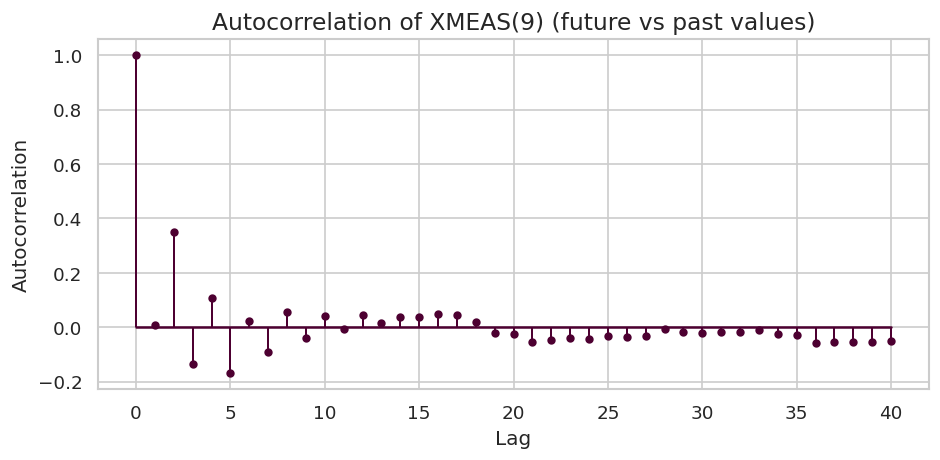

In [12]:
ensure_data_loaded()

if "XMEAS(9)" in df_features.columns:
    ac_var = "XMEAS(9)"
else:
    ac_var = df_features.columns[0]

n_points_acf = min(5000, len(df_features))
series_acf = df_features[ac_var].iloc[:n_points_acf]

max_lags = 40
acf_vals = acf(series_acf, nlags=max_lags, fft=True)

plt.figure(figsize=(8, 4))
markerline, stemlines, baseline = plt.stem(range(max_lags + 1), acf_vals)
plt.setp(stemlines, linewidth=1.2)
plt.setp(markerline, markersize=4)

plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title(f"Autocorrelation of {ac_var} (future vs past values)")
plt.tight_layout()
plt.show()

**Interpretation**

- The autocorrelation starts at 1 (perfect self-correlation) and decays
  **gradually**, staying positive for many lags.
- This means the current value of XMEAS(9) is still influenced by values
  from several time steps in the past.

# 4. SUMMARY

The Tennessee Eastman dataset is a long, regularly sampled multivariate time series with ordered timestamps, no problematic gaps or duplicates, and negligible missing data.

From the STATUS variable, the process is in normal operation (STATUS = 0) only about half the time; the remaining observations correspond to various fault or disturbed conditions, so normal and faulty conditions are both well represented.

For a representative sensor (XMEAS(9)), the time-series plots show smooth trajectories within a stable range during normal operation. Rolling statistics remain stable, and the stationarity test supports treating normal behaviour as a stable reference. At the same time, the autocorrelation function decays slowly, indicating strong temporal dependence and clear process “memory.”

These patterns motivate our modelling step: using PCA and contribution plots for multivariate detection and diagnosis, and dynamic extensions (e.g., time-windowed PCA / CVA / CVDA) to capture the temporal structure when analysing fault evolution.

The next section (Methodological Framework) answers exactly this, using the data properties revealed by the EDA as design constraints.